<div>
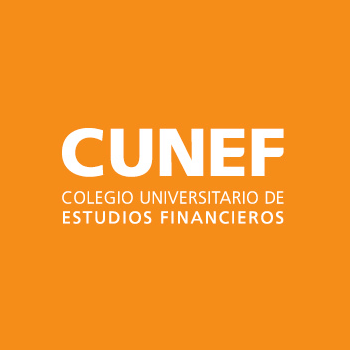
</div>


# **BioNTech SE**

## *Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación del dato*
Se procede a leer el archivo CSV del precio histórico y volumen de acciones de la empresa BioNTech SE (BNTX).

- Fuente: https://finance.yahoo.com/quote/BNTX/history?period1=1570665600&period2=1651881600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [3]:
df_bntx = pd.read_csv("BNTX2.csv")
df_bntx['Date'] = pd.to_datetime(df_bntx['Date'])
df_bntx = df_bntx.set_index("Date")
df_bntx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-10,16.50,16.698999,13.010,14.24,14.24,2805800
2019-10-11,15.34,15.340000,13.500,13.82,13.82,1364300
2019-10-14,13.83,13.910000,12.525,12.75,12.75,899100
2019-10-15,12.99,13.000000,12.530,12.92,12.92,484700
2019-10-16,13.20,13.880000,12.610,12.94,12.94,524200


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [4]:
type(df_bntx) #comprobamos que en efecto es un DataFrame

pandas.core.frame.DataFrame

In [13]:
ohlc_dict = {'Open':'first',
             'High':'max',
             'Low':'min',
             'Close': 'last',
             'Volume': 'sum'}
df_bntx = df_bntx.resample('MS', # Pondremos MS en vez de M para que se ubique a primeros de mes
                           closed='right', 
                           label='right').agg(ohlc_dict)
df_bntx.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-01,16.500000,21.990000,12.525000,16.520000,9028800
2019-12-01,17.049999,23.400000,17.030001,21.980000,2102300
2020-01-01,22.660000,38.750000,20.719999,33.880001,4138000
2020-02-01,35.750000,48.849998,28.500000,29.209999,6224700
2020-03-01,29.799999,35.099998,28.690001,35.099998,3505700


## *Graficación de la serie temporal*

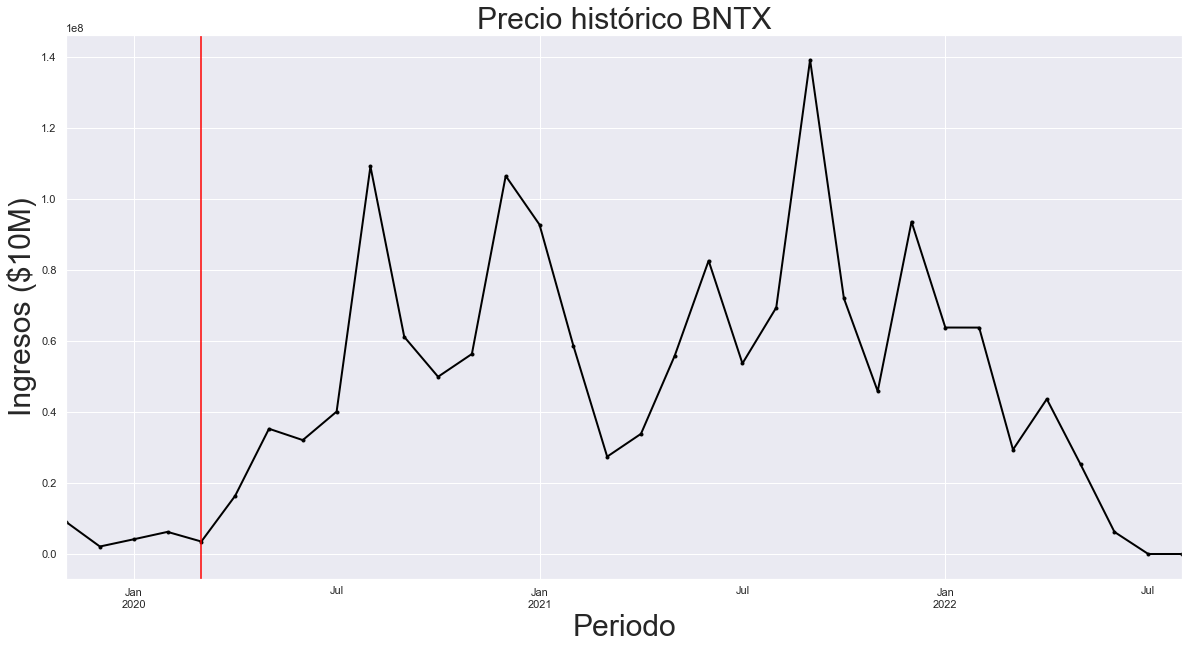

In [18]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_bntx['Volume'].plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Precio histórico BNTX', fontsize = 30) 
fig.set_ylabel('Ingresos ($10M)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

En el gráfico no se aprecia una estacionalidad muy clara, pues hay máximos y mínimos que se muestran de manera irregular a lo largo del eje del periodo. En cambio, se puede apreciar que ha habido una tendencia muy creciente desde el momento que se inicia la pandemia por COVID-19, debido a que BioNTech es una de las empresas líderes en desarrollo de vacunas y también debido a que fue (y es) una de las entidades que han apostado muchos países y muchas corporaciones para el desarrollo de la vacuna contra el Coronavirus, de ahí que el precio de las acciones se hayan podido revalorizar hasta un 700%.
- Fuente: https://www.businessinsider.es/cuanto-dinero-habrias-ganado-invertir-1000-euros-acciones-biontech-754191

A continuación, analizaremos mejor su estacionalidad y su tendencia mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

Ahora vamos a hacer el cálculo y la representación gráfica de la media y de la varianza:

In [8]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [9]:
mean = split_and_summarize(df_bntx, 'Volume', 4, np.mean)

variance = split_and_summarize(df_bntx, 'Volume', 4, np.var)

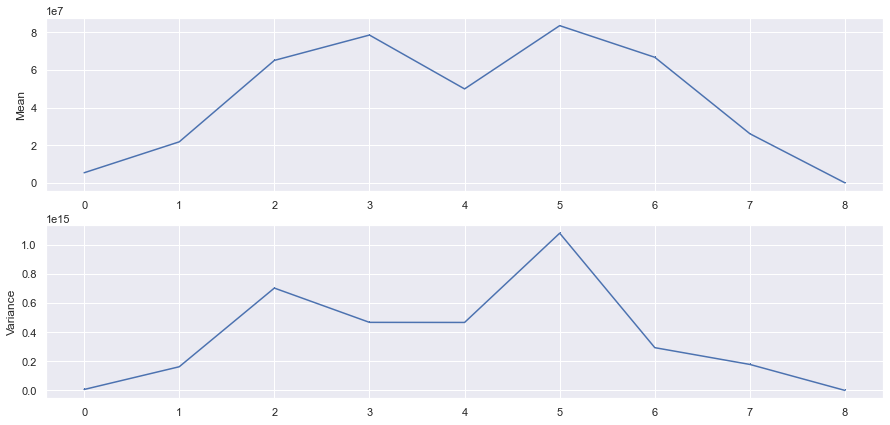

In [10]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

A continuación vamos a analizar el comportamiento mensual:

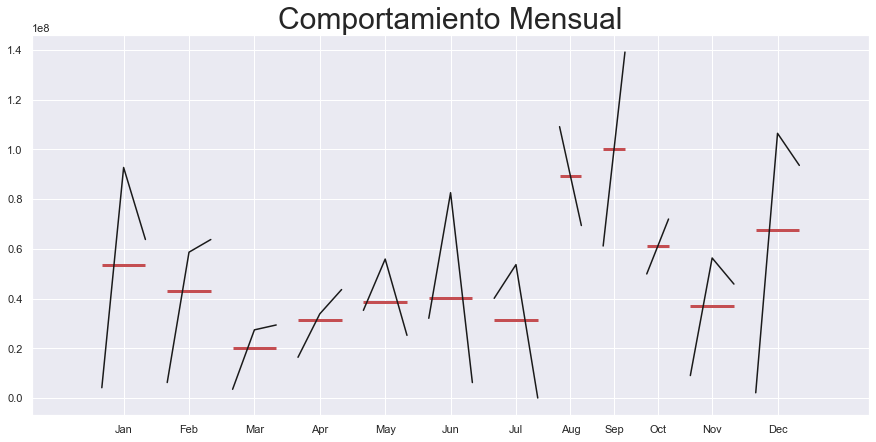

In [11]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_bntx['Volume'], ax=ax)
ax.set_title('Comportamiento Mensual', fontsize = 30);

Lo representamos también con box plots:

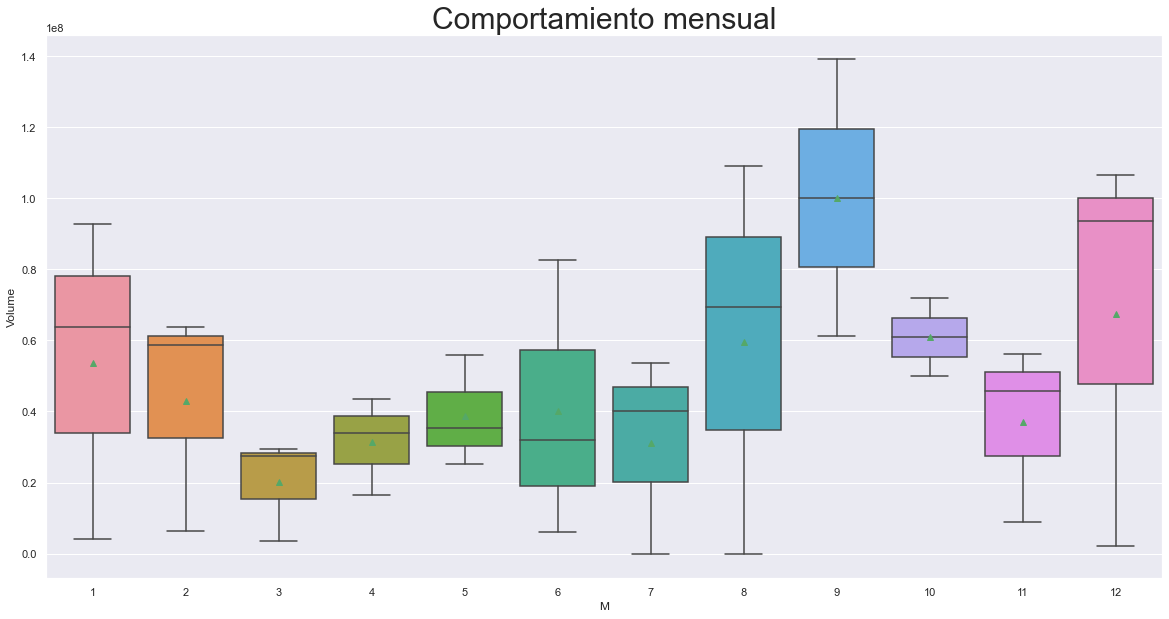

In [16]:
df_bntx['M'] = df_bntx.index.month
sns.boxplot(data = df_bntx, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_title('Comportamiento mensual', fontsize = 30);

Por último, el desglose de la estacionalidad, de la tendencia y de los residuos para analizarlo:

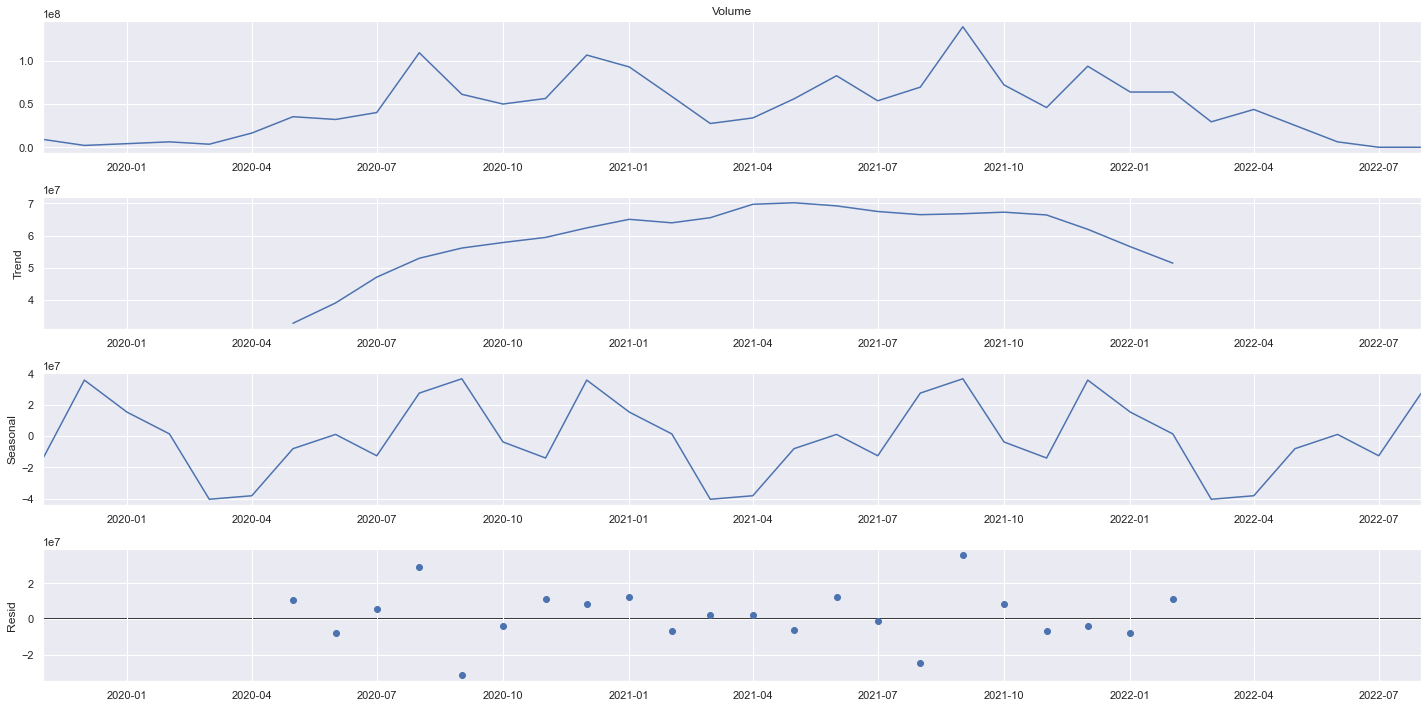

In [23]:
desglose = seasonal_decompose(df_bntx['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Como análisis, podemos decir que:
- Que hubo una tendencia creciente muy fuerte en la época del desarrollo de la vacuna Pfizer para el COVID-19 por lo que habíamos explicado anteriormente, ahora parece que está tomando una tendencia decreciente desde septiembre del 2021.
- La estacionalidad no es nada clara, se puede intuir por los comportamientos mensuales que los meses de más revalorización de BioNTech son julio y agosto, aunque en la representación de la serie temporal no se ve que se repitan dichas acentuaciones en los mismos meses del año. Por otra parte, la media y la varianza no son constantes a lo largo del periodo, de ahí que no se aprecie que ni sea una serie estacional ni que tenga estacionariedad.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.